In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
%matplotlib inline

# 4.2.5 Challenge - Boston Marathon

You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

## Goal: Look for something!

## Initial Data Processing

In [2]:
# Load in 2014 data
df = pd.read_csv('boston2014.csv')

# Drop columns not related to race performance.
df = df.drop(columns=['name', 'bib', 'ctz', 'state', 'country', 'city'])

# Remove hyphens from missing entries
df = df.replace(to_replace='-', value='')

# Convert splits to numeric
splits = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k' ]
for split in splits:
    df[split] = pd.to_numeric(df[split])

# Binarize gender so 1 = female, 0 = male
df['gender'] = np.where(df['gender']=='F', 1, 0)

# Drop missing data
df = df.dropna()

In [3]:
# Split data into smaller set for memory reasons
from sklearn.model_selection import train_test_split
df1, df2 = train_test_split(df, test_size=0.90, random_state=42)

# Normalize smaller dataset
df1_norm = normalize(df1)

## Clustering Models

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [5]:
# Specify features - focus on splits every 10k and final time
X = df1.loc[:, ['10k', '20k', '30k', '40k', 'overall']]
X_norm = normalize(X)

### K Means

In [6]:
# Run k means model
for k in np.arange(2, 7, 1):
    model = KMeans(n_clusters=k, random_state=42).fit(X_norm)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

K: 2, silhouette: 0.9490132196805277
K: 3, silhouette: 0.9046569578896213
K: 4, silhouette: 0.8676181730422375
K: 5, silhouette: 0.8072241470971726
K: 6, silhouette: 0.7894699301402841


### Mean Shift

In [7]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Set bandwidth estimator
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=500)

# Declare and fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Get labels, number of clusters, similarity score
labels = ms.labels_
n_clusters = len(np.unique(labels))
silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
print('K: {}, silhouette: {}'.format(n_clusters, silhouette))

K: 28, silhouette: 0.8208318952276669


### Spectral Clustering

In [8]:
from sklearn.cluster import SpectralClustering

# Run spectral clustering over range of k values
for k in np.arange(2, 4, 1):
    sc = SpectralClustering(n_clusters=k, random_state=42).fit(X_norm)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

# Memory error if run on higher k

K: 2, silhouette: 0.7894699301402841
K: 3, silhouette: 0.7894699301402841


### Affinity Propagation

In [9]:
from sklearn.cluster import AffinityPropagation

# Run and fit model
af = AffinityPropagation().fit(X_norm)

# Get number of clusters
cluster_centers_indices = af.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)
print('K: {}'.format(n_clusters))

K: 1029


### Best Model: K-Means

In [27]:
# PCA for plotting.  Reduce to 2 components
pca = PCA(n_components=2)
pca_X = pca.fit(X_norm).transform(X_norm)

# Get cluster assignments with k=2
model = KMeans(n_clusters=2, random_state=42).fit(X_norm)
labels = model.labels_
df1['cluster'] = labels

c:\users\mtracy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


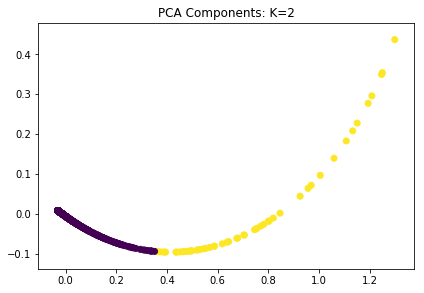

In [33]:
# Plot PCA components and clusters
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=df1['cluster'])
plt.tight_layout()
plt.title('PCA Components: K=2')
plt.show()

In [31]:
# Summary stats, overall time by cluster
df1.groupby(['cluster'])['overall'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,3112.0,16400.417738,9093.401548,481.0,8366.75,16496.0,24471.75,31874.0
1,52.0,230.750000,127.684795,2.0,143.50,230.0,335.00,456.0


In [39]:
# Summary stats, gender distribution by cluster
df1.groupby(['cluster'])['gender'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,3112.0,0.460797,0.498541,0.0,0.0,0.0,1.0,1.0
1,52.0,0.096154,0.297678,0.0,0.0,0.0,0.0,1.0


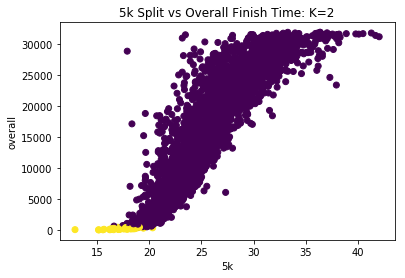

In [38]:
# Plot 5k split vs overall finish
plt.scatter(df1['5k'], df1['overall'], c=df1['cluster'])
plt.xlabel('5k')
plt.ylabel('overall')
plt.title('5k Split vs Overall Finish Time: K=2')
plt.show()

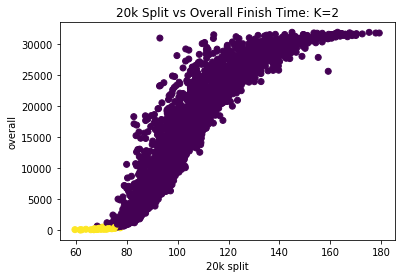

In [36]:
# Plot 20k split vs overall finish time
plt.scatter(df1['20k'], df1['overall'], c=df1['cluster'])
plt.xlabel('20k split')
plt.ylabel('overall')
plt.title('20k Split vs Overall Finish Time: K=2')
plt.show()

K Means with k=2 was identified as the being the best clustering solution on the subset of data used here.  Graphing the PCA components isn't very helpful.  No natural clusters are apparent.  Summary statistics show:
* Majority of data contained in cluster 0
* Cluster 1 has a much lower mean overall time than cluster 0
* Cluster 1 is predominantly men
* Clustering appears to be identifying fastest runners only

No great stories found here...